<div style="text-align: right">Udacity Machine Learning Nanodegree, Final Project, August 2020</div>
<div style="text-align: right">Author: Zhicheng Ma</div>

# Student_Performance_Analysis


<br></br>
<center>
    <img src = "images/boy_question.png" width = 400/>
</center>

<br></br>
When I was young, I heard a lot of strange questions and requests.

## • My mom always tells me that puppy love (crush, 早恋), internet, and games would put down my grade          
#### But, could that happen? o(￣ヘ￣o＃)
## • My aunt said a good relationship of the parents and even the career of the parents could affect children’s grades
#### But, is that true? Σ( ° △ °|||)︴
## • My teacher said she know how would I perform in the final exam by reading my previous tests
#### But, is that possible? ┑(￣Д ￣)┍
<br></br>
<br></br>
There are so many rumors and myths in the field of education...
<br></br>
We want to find out which are trues or not ლ(•̀ _ •́ ლ)

# Chosen Dataset
<br></br>
<center>
    <img src = "images/UCI.png" width = 400/>
</center>
<br></br>
<center>http://archive.ics.uci.edu/ml/datasets/Student+Performance#</center>
<br></br>

### A dataset contains math grades from a high school in Portugal 
<table border="0" bgcolor="#000000">
    <tr>
        <td>
            <img src = "images/portgual.png" width = 400/>
        </td>
        <td>
            <img src = "images/open-math-icon-11563164013hkrwcjujyy.png" width = 400/>
        </td>
    </tr>
</table>

# Apply Portuguese Trimester to American Semester
## G1 -> the final exam of the first semester
## G2 -> the midterm of the second semester
## G3 -> the final exam of the second semester (the Goal!)

# Chosen Model
## Recurrent Neutorn Network + Random Forest
<table border="0" bgcolor="#000000">
    <tr>
        <td>
            <img src = "images/NN.png" width = 300/>
        </td>
        <td>
            <img src = "images/RF.png" width = 400/>
        </td>
    </tr>
</table>
<br></br>
<br></br>
<br></br>

# 0. Library dependencies

In [24]:
import os
import math
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
sns.set_palette("bright")
import matplotlib.pyplot as plt
import boto3
import sagemaker
from sklearn.model_selection import train_test_split
from sagemaker.pytorch import PyTorch
from sagemaker.sklearn.estimator import SKLearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
from sklearn.externals import joblib

# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

# 1. Explor data

### Take a first look of the dataset.

In [141]:
students_data = pd.read_csv('data/student-mat.csv', sep = ';')
students_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


### Check how many different features (columns) in the original dataset and types of them.

In [142]:
students_data.dtypes, len(students_data)

(school        object
 sex           object
 age            int64
 address       object
 famsize       object
 Pstatus       object
 Medu           int64
 Fedu           int64
 Mjob          object
 Fjob          object
 reason        object
 guardian      object
 traveltime     int64
 studytime      int64
 failures       int64
 schoolsup     object
 famsup        object
 paid          object
 activities    object
 nursery       object
 higher        object
 internet      object
 romantic      object
 famrel         int64
 freetime       int64
 goout          int64
 Dalc           int64
 Walc           int64
 health         int64
 absences       int64
 G1             int64
 G2             int64
 G3             int64
 dtype: object,
 395)

# 2. Clean data

In [143]:
# These features are for schools' identity. None of them will be use in this project.
students_data2 = students_data.drop(['school', 'Dalc', 'Walc', 'nursery'], axis = 1)
students_data2.head()

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,internet,romantic,famrel,freetime,goout,health,absences,G1,G2,G3
0,F,18,U,GT3,A,4,4,at_home,teacher,course,...,no,no,4,3,4,3,6,5,6,6
1,F,17,U,GT3,T,1,1,at_home,other,course,...,yes,no,5,3,3,3,4,5,5,6
2,F,15,U,LE3,T,1,1,at_home,other,other,...,yes,no,4,3,2,3,10,7,8,10
3,F,15,U,GT3,T,4,2,health,services,home,...,yes,yes,3,2,2,5,2,15,14,15
4,F,16,U,GT3,T,3,3,other,other,home,...,no,no,4,3,2,5,4,6,10,10


# 3. Preprocess data

### Replace all object type to int64 

In [144]:
# check how many kinds of object type in dataset
object_list  = ['address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
                'schoolsup', 'famsup', 'paid', 'activities', 'higher', 'internet', 
                'romantic']
print([set(students_data2[col]) for col in students_data2[object_list]])

[{'U', 'R'}, {'GT3', 'LE3'}, {'T', 'A'}, {'at_home', 'health', 'teacher', 'services', 'other'}, {'at_home', 'health', 'teacher', 'services', 'other'}, {'reputation', 'home', 'other', 'course'}, {'father', 'mother', 'other'}, {'yes', 'no'}, {'yes', 'no'}, {'yes', 'no'}, {'yes', 'no'}, {'yes', 'no'}, {'yes', 'no'}, {'yes', 'no'}]


In [145]:
# define Female -> 0, Male -> 1
students_data2.loc[students_data2.sex == 'F', 'sex'] = 0
students_data2.loc[students_data2.sex == 'M', 'sex'] = 1
set(students_data2.sex), len(students_data2)

({0, 1}, 395)

In [146]:
# define R -> 0, U -> 1
students_data2.loc[students_data2.address == 'R', 'address'] = 0
students_data2.loc[students_data2.address == 'U', 'address'] = 1
set(students_data2.address), len(students_data2)

({0, 1}, 395)

In [147]:
# define LE3 -> 0, GT3 -> 1
students_data2.loc[students_data2.famsize == 'LE3', 'famsize'] = 0
students_data2.loc[students_data2.famsize == 'GT3', 'famsize'] = 1
set(students_data2.famsize), len(students_data2)

({0, 1}, 395)

In [148]:
# define APART -> 0, TOGETHER -> 1
students_data2.loc[students_data2.Pstatus == 'A', 'Pstatus'] = 0
students_data2.loc[students_data2.Pstatus == 'T', 'Pstatus'] = 1
set(students_data2.Pstatus), len(students_data2)

({0, 1}, 395)

In [149]:
# define at_home -> 0, health -> 1, other -> 2, services -> 3, teacher -> 4
students_data2.loc[students_data2.Mjob == 'at_home', 'Mjob'] = 0
students_data2.loc[students_data2.Mjob == 'health', 'Mjob'] = 1
students_data2.loc[students_data2.Mjob == 'other', 'Mjob'] = 2
students_data2.loc[students_data2.Mjob == 'services', 'Mjob'] = 3
students_data2.loc[students_data2.Mjob == 'teacher', 'Mjob'] = 4
set(students_data2.Mjob), len(students_data2)

({0, 1, 2, 3, 4}, 395)

In [150]:
# define at_home -> 0, health -> 1, other -> 2, services -> 3, teacher -> 4
students_data2.loc[students_data2.Fjob == 'at_home', 'Fjob'] = 0
students_data2.loc[students_data2.Fjob == 'health', 'Fjob'] = 1
students_data2.loc[students_data2.Fjob == 'other', 'Fjob'] = 2
students_data2.loc[students_data2.Fjob == 'services', 'Fjob'] = 3
students_data2.loc[students_data2.Fjob == 'teacher', 'Fjob'] = 4
set(students_data2.Fjob), len(students_data2)

({0, 1, 2, 3, 4}, 395)

In [151]:
# define course -> 0, home -> 1, other -> 2, reputation -> 3
students_data2.loc[students_data2.reason == 'course', 'reason'] = 0
students_data2.loc[students_data2.reason == 'home', 'reason'] = 1
students_data2.loc[students_data2.reason == 'other', 'reason'] = 2
students_data2.loc[students_data2.reason == 'reputation', 'reason'] = 3
set(students_data2.reason), len(students_data2)

({0, 1, 2, 3}, 395)

In [152]:
# define father -> 0, mother -> 1, other -> 2
students_data2.loc[students_data2.guardian == 'father', 'guardian'] = 0
students_data2.loc[students_data2.guardian == 'mother', 'guardian'] = 1
students_data2.loc[students_data2.guardian == 'other', 'guardian'] = 2
set(students_data2.guardian), len(students_data2)

({0, 1, 2}, 395)

In [153]:
# define no -> 0, yes -> 1
students_data2.loc[students_data2.schoolsup == 'no', 'schoolsup'] = 0
students_data2.loc[students_data2.schoolsup == 'yes', 'schoolsup'] = 1
set(students_data2.schoolsup), len(students_data2)

({0, 1}, 395)

In [154]:
# define no -> 0, yes -> 1
students_data2.loc[students_data2.famsup == 'no', 'famsup'] = 0
students_data2.loc[students_data2.famsup == 'yes', 'famsup'] = 1
set(students_data2.famsup), len(students_data2)

({0, 1}, 395)

In [155]:
# define no -> 0, yes -> 1
students_data2.loc[students_data2.paid == 'no', 'paid'] = 0
students_data2.loc[students_data2.paid == 'yes', 'paid'] = 1
set(students_data2.paid), len(students_data2)

({0, 1}, 395)

In [156]:
# define no -> 0, yes -> 1
students_data2.loc[students_data2.activities == 'no', 'activities'] = 0
students_data2.loc[students_data2.activities == 'yes', 'activities'] = 1
set(students_data2.activities), len(students_data2)

({0, 1}, 395)

In [157]:
# define no -> 0, yes -> 1
students_data2.loc[students_data2.higher == 'no', 'higher'] = 0
students_data2.loc[students_data2.higher == 'yes', 'higher'] = 1
set(students_data2.higher), len(students_data2)

({0, 1}, 395)

In [158]:
# define no -> 0, yes -> 1
students_data2.loc[students_data2.internet == 'no', 'internet'] = 0
students_data2.loc[students_data2.internet == 'yes', 'internet'] = 1
set(students_data2.internet), len(students_data2)

({0, 1}, 395)

In [159]:
# define no -> 0, yes -> 1
students_data2.loc[students_data2.romantic == 'no', 'romantic'] = 0
students_data2.loc[students_data2.romantic == 'yes', 'romantic'] = 1
set(students_data2.romantic), len(students_data2)

({0, 1}, 395)

In [160]:
# Check again
print([set(students_data2[col]) for col in students_data2[object_list]])

[{0, 1}, {0, 1}, {0, 1}, {0, 1, 2, 3, 4}, {0, 1, 2, 3, 4}, {0, 1, 2, 3}, {0, 1, 2}, {0, 1}, {0, 1}, {0, 1}, {0, 1}, {0, 1}, {0, 1}, {0, 1}]


In [161]:
students_data2.head()

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,internet,romantic,famrel,freetime,goout,health,absences,G1,G2,G3
0,0,18,1,1,0,4,4,0,4,0,...,0,0,4,3,4,3,6,5,6,6
1,0,17,1,1,1,1,1,0,2,0,...,1,0,5,3,3,3,4,5,5,6
2,0,15,1,0,1,1,1,0,2,2,...,1,0,4,3,2,3,10,7,8,10
3,0,15,1,1,1,4,2,1,3,1,...,1,1,3,2,2,5,2,15,14,15
4,0,16,1,1,1,3,3,2,2,1,...,0,0,4,3,2,5,4,6,10,10


### Extract features

### In this project, I would like to separate the original dataset into three different sets:
<center>
    <img src = "images/dataset.png"/>
</center>

### Set A -> basic data + G1 + G2 (Contains the most of the original dataset)

### Set B -> basic data + G1 (Contains less information than Set A)

### Set C -> basic data ONLY (Contains the least information)

In [162]:
setA = students_data2.drop(['G3'], axis = 1)
setA.head()

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,higher,internet,romantic,famrel,freetime,goout,health,absences,G1,G2
0,0,18,1,1,0,4,4,0,4,0,...,1,0,0,4,3,4,3,6,5,6
1,0,17,1,1,1,1,1,0,2,0,...,1,1,0,5,3,3,3,4,5,5
2,0,15,1,0,1,1,1,0,2,2,...,1,1,0,4,3,2,3,10,7,8
3,0,15,1,1,1,4,2,1,3,1,...,1,1,1,3,2,2,5,2,15,14
4,0,16,1,1,1,3,3,2,2,1,...,1,0,0,4,3,2,5,4,6,10


In [163]:
setB = students_data2.drop(['G2', 'G3'], axis = 1)
setB.head()

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,activities,higher,internet,romantic,famrel,freetime,goout,health,absences,G1
0,0,18,1,1,0,4,4,0,4,0,...,0,1,0,0,4,3,4,3,6,5
1,0,17,1,1,1,1,1,0,2,0,...,0,1,1,0,5,3,3,3,4,5
2,0,15,1,0,1,1,1,0,2,2,...,0,1,1,0,4,3,2,3,10,7
3,0,15,1,1,1,4,2,1,3,1,...,1,1,1,1,3,2,2,5,2,15
4,0,16,1,1,1,3,3,2,2,1,...,0,1,0,0,4,3,2,5,4,6


In [164]:
setC = students_data2.drop(['G1', 'G2', 'G3'], axis = 1)
setC.head()

,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,paid,activities,higher,internet,romantic,famrel,freetime,goout,health,absences
0,0,18,1,1,0,4,4,0,4,0,...,0,0,1,0,0,4,3,4,3,6
1,0,17,1,1,1,1,1,0,2,0,...,0,0,1,1,0,5,3,3,3,4
2,0,15,1,0,1,1,1,0,2,2,...,1,0,1,1,0,4,3,2,3,10
3,0,15,1,1,1,4,2,1,3,1,...,1,1,1,1,1,3,2,2,5,2
4,0,16,1,1,1,3,3,2,2,1,...,1,0,1,0,0,4,3,2,5,4


### Similarity, I would like to set three different levels of the goal:
<center>
    <img src = "images/output_design.png"/>
</center>

### A_output -> Pass/ Fail (The easiest one)

### B_output -> 5 levels grade (Increasing the difficulty)

### C_output -> Actual score (The most difficult one. Predicting the score in the final exam 'G3')

In [165]:
# Extract G3 first
goal = students_data2['G3']
goal.head()

0     6
1     6
2    10
3    15
4    10
Name: G3, dtype: int64

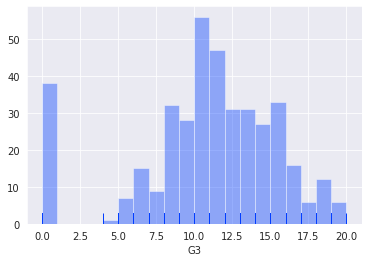

In [166]:
sns.distplot(goal, kde=False, bins=20, rug=True)

In [167]:
# Set rules for pass/fail: score >= 10 -> pass (1), otherwise -> fail (0)
def A_output(data):
    out = []
    out.append([1 if int(score) >= 10 else 0 for score in data])
    return np.squeeze(out)

In [168]:
outputA = A_output(goal)
outputA[:5]

array([0, 0, 1, 1, 1])

In [169]:
print("Numbers of pass: " + str(sum(outputA)))
print("NUmbers of fail: " + str(len(outputA) - sum(outputA)))

Numbers of pass: 265
NUmbers of fail: 130


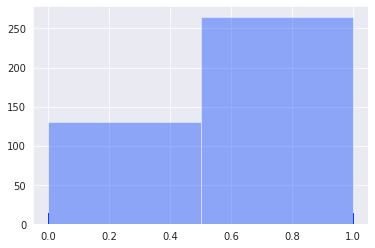

In [170]:
sns.distplot(outputA, kde=False, bins=2, rug=True)

In [177]:
# Set one-hot encoder
outputA = pd.get_dummies(outputA)
view = outputA[:10]
view.columns = ['fail', 'pass']
view['origin'] = goal
view

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,fail,pass,origin
0,1,0,6
1,1,0,6
2,0,1,10
3,0,1,15
4,0,1,10
5,0,1,15
6,0,1,11
7,1,0,6
8,0,1,19
9,0,1,15


In [178]:
# Set rules for 5 levels grade: 
    # score ∈ [0, 9] -> 0
    # score ∈ [10, 11] -> 1
    # score ∈ [12, 13] -> 2
    # score ∈ [14, 15] -> 3
    # score ∈ [16, 20] -> 4
def B_output(data):
    out = []
    for ele in data:
        score = int(ele)
        if score >= 16:
            out.append(4)
        elif score >= 14:
            out.append(3)
        elif score >= 12:
            out.append(2)
        elif score >= 10:
            out.append(1)
        else:
            out.append(0)
    return out

In [179]:
outputB = B_output(goal)
len(outputB), set(outputB)

(395, {0, 1, 2, 3, 4})

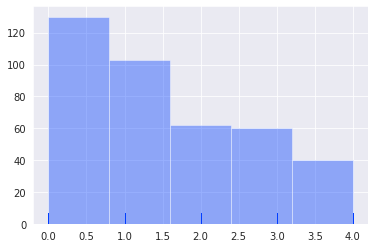

In [180]:
sns.distplot(outputB, kde=False, bins=5, rug=True)

In [182]:
outputB = pd.get_dummies(outputB)
view = outputB[:10]
view.columns = ['0~9', '10~11', '12~13', '14~15', '16~20']
view['origin'] = goal
view

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,0~9,10~11,12~13,14~15,16~20,origin
0,1,0,0,0,0,6
1,1,0,0,0,0,6
2,0,1,0,0,0,10
3,0,0,0,1,0,15
4,0,1,0,0,0,10
5,0,0,0,1,0,15
6,0,1,0,0,0,11
7,1,0,0,0,0,6
8,0,0,0,0,1,19
9,0,0,0,1,0,15


In [183]:
# Because we want to predict actual score in outputC, only need to change another type for G3
def C_output(data):
    out = []
    out.append([np.float32(score) for score in data])
    return np.squeeze(out)

In [184]:
outputC = C_output(goal)
outputC[:10], len(outputC), type(outputC[0])

(array([ 6.,  6., 10., 15., 10., 15., 11.,  6., 19., 15.], dtype=float32),
 395,
 numpy.float32)

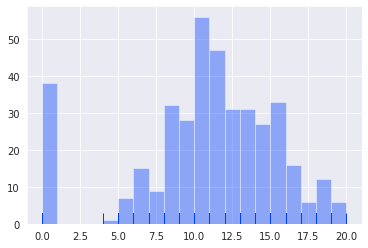

In [185]:
sns.distplot(outputC, kde=False, bins=20, rug=True)

### Save to csv file

In [186]:
data_dir = 'data'
setA.to_csv(os.path.join(data_dir, 'setA.csv'), index=False)
setB.to_csv(os.path.join(data_dir, 'setB.csv'), index=False)
setC.to_csv(os.path.join(data_dir, 'setC.csv'), index=False)

pd.DataFrame(outputA).to_csv(os.path.join(data_dir, 'outputA.csv'), header=False, index=False)
pd.DataFrame(outputB).to_csv(os.path.join(data_dir, 'outputB.csv'), header=False, index=False)
pd.DataFrame(outputC).to_csv(os.path.join(data_dir, 'outputC.csv'), header=False, index=False)

### Ready to work!!!

In [25]:
data_dir = 'data'
setA = pd.read_csv(os.path.join(data_dir, 'setA.csv'), index_col=False)
setB = pd.read_csv(os.path.join(data_dir, 'setB.csv'), index_col=False)
setC = pd.read_csv(os.path.join(data_dir, 'setC.csv'), index_col=False)

outputA = pd.read_csv(os.path.join(data_dir, 'outputA.csv'), header=None, index_col=False)
outputB = pd.read_csv(os.path.join(data_dir, 'outputB.csv'), header=None, index_col=False)
outputC = pd.read_csv(os.path.join(data_dir, 'outputC.csv'), header=None, index_col=False)

# Experiment 1: Would my mom's concerns become true, such as puppy love and the internet will push me to fail the course?  `"Bad" Activities + Pass/Fail`

### My mom always cares about these bad activities:
   * Activities -> extra-curricular activities (binary: yes or no)
   * Internet -> internet access at home (binary: yes or no)
   * Romantic -> with a romantic relationship (binary: yes or no)
   * Freetime -> free time after school (numeric: from 1 - very low to 5 - very high)
   * Goout -> going out with friends (numeric: from 1 - very low to 5 - very high)

In [281]:
bad_activities = pd.DataFrame(setC, columns=['activities', 'internet', 'romantic', 'freetime', 'goout'])
bad_activities.head()

,activities,internet,romantic,freetime,goout
0,0,0,0,3,4
1,0,1,0,3,3
2,0,1,0,3,2
3,1,1,1,2,2
4,0,0,0,3,2


In [375]:
# split data into training and test datasets
X_train, X_test, y_train, y_test = None, None, None, None # make sure X and y are empty
X_train, X_test, y_train, y_test = train_test_split(bad_activities, outputA, test_size = 0.2, random_state=42)

In [376]:
len(X_train), len(y_train), len(X_train.columns), len(y_train.columns)

(316, 316, 5, 2)

In [377]:
len(X_test), len(y_test), len(X_test.columns), len(y_test.columns)

(79, 79, 5, 2)

In [378]:
# Save training data and test data
sagemaker_dir = 'sagemaker_data'
exp_dir = 'exp1'
pd.concat([pd.DataFrame(y_train), pd.DataFrame(X_train)],
          axis=1).to_csv(os.path.join(sagemaker_dir, exp_dir, 'train.csv'), 
                    header=False, index=False)
pd.concat([pd.DataFrame(y_test), pd.DataFrame(X_test)],
          axis=1).to_csv(os.path.join(sagemaker_dir, exp_dir, 'test.csv'), 
                    header=False, index=False)

So, based on "bad" activities above, I would assume a null hypothesis and an alternative hypothesis.
### Null Hypothesis: 
**`Predict Pass/Fail with more than 80% accuracy by using those "bad" activities.`**
### Alternative Hypothesis
**`Prediction accuracy lower than 80%.`**

Since we want to predict the result to Pass/Fail pattern, it is a classic Binomial Distribution problem. Therefore, I would use `Binomial Distribution formula` and `single-tail test` to examine the null hypothesis.
<center>
    <img src = 'images/Binomial_Distribution.png', width = 500>
</center>

**`Significance Value: 5%`**

In [379]:
def Binomial_Distribution(n, p):
    out = []
    critical_region = 0
    critical_value = 0.0
    for x in range(0, n + 1):
        cx = math.factorial(float(n)) / (math.factorial(float(x)) * math.factorial(float(n - x)))
        ux = (p ** float(x)) * ((1.0 - p) ** float(n - x))
        px = round(cx * ux, 5)
        out.append(px)
        if critical_value < 0.05:
            critical_value += px
            critical_region += 1
    return out, critical_region

In [380]:
binomial, critical_region = Binomial_Distribution(len(y_test), 0.8)
binomial[:10], len(binomial)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 80)

In [381]:
len(y_test), critical_region

(79, 58)

**`We got the critical region ∈ [0, 58]. Thus, we could only accept the null hypothesis when we obtain more than 58 correct prediction among total 79 inputs.`**

In [382]:
# Upload to s3
prefix = 'student_analysis'
data_s3 = sagemaker_session.upload_data(path=os.path.join(sagemaker_dir, exp_dir),
                                        bucket=bucket,
                                        key_prefix=prefix)
data_s3

's3://sagemaker-us-east-1-980497197870/student_analysis'

### Create Pytorch estimator

In [383]:
model = PyTorch(entry_point='train.py',
                source_dir='pytorch_model',
                role=role,
                train_instance_count=1,
                train_instance_type='ml.p2.xlarge',
                sagemaker_session=sagemaker_session,
                framework_version='1.5.0',
                hyperparameters={'epochs': 500,
                                 'input_features': 5,
                                 'hidden_dim': 10,
                                 'output_dim': 2,
                                 'batch-size': 32})

In [384]:
model.fit({'train': data_s3})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-23 07:54:41 Starting - Starting the training job...
2020-08-23 07:54:43 Starting - Launching requested ML instances......
2020-08-23 07:55:54 Starting - Preparing the instances for training......
2020-08-23 07:56:56 Downloading - Downloading input data...
2020-08-23 07:57:27 Training - Downloading the training image..............bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-23 07:59:49,511 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-23 07:59:49,535 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-23 07:59:49,744 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-23 07:59:50,050 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020-08-23 07:59:50,050 sagemaker-containers INFO     Generating setup.cfg
2020-08-23 07:5


2020-08-23 07:59:48 Training - Training image download completed. Training in progress.Epoch: 23, Loss: 0.6397306740283966
Epoch: 24, Loss: 0.638124531507492
Epoch: 25, Loss: 0.6416370928287506
Epoch: 26, Loss: 0.6362318277359009
Epoch: 27, Loss: 0.6377622127532959
Epoch: 28, Loss: 0.6381886184215546
Epoch: 29, Loss: 0.6322534143924713
Epoch: 30, Loss: 0.6247107863426209
Epoch: 31, Loss: 0.6353905498981476
Epoch: 32, Loss: 0.6284716367721558
Epoch: 33, Loss: 0.6229830503463745
Epoch: 34, Loss: 0.6326348781585693
Epoch: 35, Loss: 0.6252899765968323
Epoch: 36, Loss: 0.624338012933731
Epoch: 37, Loss: 0.6255790829658509
Epoch: 38, Loss: 0.6288822174072266
Epoch: 39, Loss: 0.6213782072067261
Epoch: 40, Loss: 0.6287903010845184
Epoch: 41, Loss: 0.6278597593307496
Epoch: 42, Loss: 0.626840204000473
Epoch: 43, Loss: 0.6301314771175385
Epoch: 44, Loss: 0.624213582277298
Epoch: 45, Loss: 0.620563805103302
Epoch: 46, Loss: 0.6279617309570312
Epoch: 47, Loss: 0.6217678189277649
Epoch: 48, Loss: 

Epoch: 303, Loss: 0.585381081700325
Epoch: 304, Loss: 0.5926998168230057
Epoch: 305, Loss: 0.5921186625957489
Epoch: 306, Loss: 0.578797110915184
Epoch: 307, Loss: 0.5737333416938781
Epoch: 308, Loss: 0.5874115318059921
Epoch: 309, Loss: 0.5877921253442764
Epoch: 310, Loss: 0.5780834883451462
Epoch: 311, Loss: 0.5653628587722779
Epoch: 312, Loss: 0.5768114119768143
Epoch: 313, Loss: 0.5799841940402984
Epoch: 314, Loss: 0.5809566527605057
Epoch: 315, Loss: 0.5818939745426178
Epoch: 316, Loss: 0.586630791425705
Epoch: 317, Loss: 0.5715462148189545
Epoch: 318, Loss: 0.575189334154129
Epoch: 319, Loss: 0.5948752731084823
Epoch: 320, Loss: 0.5845276921987533
Epoch: 321, Loss: 0.5775795221328736
Epoch: 322, Loss: 0.5777909249067307
Epoch: 323, Loss: 0.5720764815807342
Epoch: 324, Loss: 0.559168690443039
Epoch: 325, Loss: 0.5916381686925888
Epoch: 326, Loss: 0.5735719472169876
Epoch: 327, Loss: 0.5820955604314804
Epoch: 328, Loss: 0.5793618530035018
Epoch: 329, Loss: 0.5866681396961212
Epoch:


2020-08-23 08:00:31 Uploading - Uploading generated training model
2020-08-23 08:00:31 Completed - Training job completed
Training seconds: 215
Billable seconds: 215


### Deploy Pytorch estimator

In [385]:
predictor = model.deploy(instance_type = 'ml.c4.xlarge',
                         initial_instance_count = 1)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!

### Test model

In [26]:
def result_pass_fail(preds):
    c = 0
    for idx in range(len(preds)):
        if (preds[idx] == y_test[idx]).all():
            c += 1
    return c, 1.0 * c / len(preds)

In [390]:
test_data = pd.read_csv(os.path.join(sagemaker_dir, exp_dir, 'test.csv'), header=None, names=None)
y_test = np.asarray(test_data.iloc[:,[0,1]])
X_test = test_data.iloc[:,2:]
X_test = X_test.astype('float32')
y_preds = np.squeeze(np.rint(predictor.predict(X_test))).astype(int)
y_preds[:10]

array([[1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [393]:
correct, p = result_pass_fail(y_preds)
print('Correct predictions: ' + str(correct) + ' among the total ' + str(len(y_preds)))
print('Accuracy score: ' + str(p))

Correct predictions: 45 among the total 79
Accuracy score: 0.569620253164557


**What a surprise! Mom was wrong, those bad activities cannot lead to failing directly.**

`However, although after predictions, we have to refuse the null hypothesis. I am still shocked by the result. Because we only use 5 background information and we could predict the result with more a half accuracy. So, what if we take all of the background information and try it again?`

# Experiment 2: Predict result by only use background information. `SetC + Pass/Fail`

In [27]:
# split data into training and test datasets
X_train, X_test, y_train, y_test = None, None, None, None # make sure X and y are empty
X_train, X_test, y_train, y_test = train_test_split(setC, outputA, test_size = 0.2, random_state=42)

In [28]:
len(X_train), len(y_train), len(X_train.columns), len(y_train.columns)

(316, 316, 26, 2)

In [29]:
len(X_test), len(y_test), len(X_test.columns), len(y_test.columns)

(79, 79, 26, 2)

In [30]:
# Save training data and test data
sagemaker_dir = 'sagemaker_data'
exp_dir = 'exp2'
pd.concat([pd.DataFrame(y_train), pd.DataFrame(X_train)],
          axis=1).to_csv(os.path.join(sagemaker_dir, exp_dir, 'train.csv'), 
                    header=False, index=False)
pd.concat([pd.DataFrame(y_test), pd.DataFrame(X_test)],
          axis=1).to_csv(os.path.join(sagemaker_dir, exp_dir, 'test.csv'), 
                    header=False, index=False)

In [31]:
# Upload to s3
prefix = 'student_analysis'
data_s3 = sagemaker_session.upload_data(path=os.path.join(sagemaker_dir, exp_dir),
                                        bucket=bucket,
                                        key_prefix=prefix)
data_s3

's3://sagemaker-us-east-1-980497197870/student_analysis'

### Create Pytorch estimator

In [27]:
model = PyTorch(entry_point='train.py',
                source_dir='pytorch_model',
                role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                sagemaker_session=sagemaker_session,
                framework_version='1.5.0',
                hyperparameters={'epochs': 500,
                                 'input_features': 26,
                                 'hidden_dim': 128,
                                 'output_dim': 2,
                                 'batch-size': 32})

In [28]:
model.fit({'train': data_s3})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-23 08:58:27 Starting - Starting the training job...
2020-08-23 08:58:29 Starting - Launching requested ML instances.........
2020-08-23 09:00:09 Starting - Preparing the instances for training...
2020-08-23 09:00:56 Downloading - Downloading input data......
2020-08-23 09:01:53 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-23 09:01:54,926 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-23 09:01:54,929 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-23 09:01:54,942 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-23 09:01:56,413 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-23 09:02:03,918 sagemaker-containers INFO     Module default_user_module_name does not provide a setu

Epoch: 24, Loss: 0.4642760932445526
Epoch: 25, Loss: 0.4486957550048828
Epoch: 26, Loss: 0.4550172030925751
Epoch: 27, Loss: 0.4660410225391388
Epoch: 28, Loss: 0.44386197030544283
Epoch: 29, Loss: 0.41977016627788544
Epoch: 30, Loss: 0.4403359144926071
Epoch: 31, Loss: 0.4159052312374115
Epoch: 32, Loss: 0.4243630349636078
Epoch: 33, Loss: 0.4273489862680435
Epoch: 34, Loss: 0.41877228021621704
Epoch: 35, Loss: 0.42680099308490754
Epoch: 36, Loss: 0.40252907276153566
Epoch: 37, Loss: 0.3662180811166763
Epoch: 38, Loss: 0.38641032129526137
Epoch: 39, Loss: 0.3847100347280502
Epoch: 40, Loss: 0.3542877554893494
Epoch: 41, Loss: 0.32655421197414397
Epoch: 42, Loss: 0.33994587808847426
Epoch: 43, Loss: 0.3331837594509125
Epoch: 44, Loss: 0.3429126307368279
Epoch: 45, Loss: 0.3300591424107552
Epoch: 46, Loss: 0.29579284489154817
Epoch: 47, Loss: 0.33767807185649873
Epoch: 48, Loss: 0.30803375244140624
Epoch: 49, Loss: 0.3043981671333313
Epoch: 50, Loss: 0.3026445433497429
Epoch: 51, Loss: 


2020-08-23 09:03:25 Uploading - Uploading generated training modelEpoch: 353, Loss: 0.01323028207407333
Epoch: 354, Loss: 0.0055889233277412135
Epoch: 355, Loss: 0.015064775303471833
Epoch: 356, Loss: 0.007887960539665072
Epoch: 357, Loss: 0.03068971451721154
Epoch: 358, Loss: 0.02428808147087693
Epoch: 359, Loss: 0.0038754558176151478
Epoch: 360, Loss: 0.008334279109840281
Epoch: 361, Loss: 0.022052050329511984
Epoch: 362, Loss: 0.017313391022616996
Epoch: 363, Loss: 0.03736816700547933
Epoch: 364, Loss: 0.02695696527371183
Epoch: 365, Loss: 0.019938741996884345
Epoch: 366, Loss: 0.024840000062249602
Epoch: 367, Loss: 0.019144115163362584
Epoch: 368, Loss: 0.0426839765306795
Epoch: 369, Loss: 0.01036188066645991
Epoch: 370, Loss: 0.01222452542060637
Epoch: 371, Loss: 0.01812296668504132
Epoch: 372, Loss: 0.00560785025882069
Epoch: 373, Loss: 0.0067313958355953215
Epoch: 374, Loss: 0.011608838420943356
Epoch: 375, Loss: 0.011200636184366886
Epoch: 376, Loss: 0.00326482355594635
Epoch:

### Deploy Pytorch estimator

In [29]:
predictor = model.deploy(instance_type = 'ml.c4.xlarge',
                         initial_instance_count = 1)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!

### Test model

In [30]:
test_data = pd.read_csv(os.path.join(sagemaker_dir, exp_dir, 'test.csv'), header=None, names=None)
y_test = np.asarray(test_data.iloc[:,[0,1]])
X_test = test_data.iloc[:,2:]
X_test = X_test.astype('float32')
y_preds = np.squeeze(np.rint(predictor.predict(X_test))).astype(int)
y_preds[:10]

array([[1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1]])

In [31]:
correct, p = result_pass_fail(y_preds)
print('Correct predictions: ' + str(correct) + ' among the total ' + str(len(y_preds)))
print('Accuracy score: ' + str(p))

Correct predictions: 58 among the total 79
Accuracy score: 0.7341772151898734


`73% accuracy? Only by using background information? Let's find out which features impact the result most.`
**To do this, train a RandomForest model could help us to find out.**

In [32]:
model = SKLearn(entry_point = 'train.py',
                source_dir = 'scikit-learn_model',
                role = role,
                train_instance_count = 1,
                train_instance_type = 'ml.c4.xlarge',
                sagemaker_session = sagemaker_session,
                framework_version = '0.20.0',
                hyperparameters = {'n-estimators': 500,
                                   'output-dim': 2})

This is not the latest supported version. If you would like to use version 0.23-1, please add framework_version=0.23-1 to your constructor.


In [33]:
%%time
model.fit({'train': data_s3})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-08-23 10:45:10 Starting - Starting the training job...
2020-08-23 10:45:12 Starting - Launching requested ML instances.........
2020-08-23 10:46:52 Starting - Preparing the instances for training......
2020-08-23 10:47:42 Downloading - Downloading input data...
2020-08-23 10:48:24 Training - Downloading the training image..2020-08-23 10:48:44,443 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-08-23 10:48:44,446 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-08-23 10:48:44,456 sagemaker_sklearn_container.training INFO     Invoking user training script.

2020-08-23 10:49:08 Uploading - Uploading generated training model2020-08-23 10:49:00,435 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-08-23 10:49:00,435 sagemaker-containers INFO     Generating setup.cfg
2020-08-23 10:49:00,436 sagemaker-containers INFO     Generating MANIFEST.in
2020-08-23 10:49:00,43

In [38]:
%%time
predictor = model.deploy(initial_instance_count = 1,
                         instance_type = 'ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!CPU times: user 303 ms, sys: 7.02 ms, total: 310 ms
Wall time: 8min 32s


In [41]:
y_preds = predictor.predict(X_test)

In [44]:
accuracy = accuracy_score(y_test, y_preds)
print(accuracy)

0.7088607594936709


In [51]:
model_file_path = 'scikit-learn_model/model.joblib'

In [52]:
rf1 = joblib.load(model_file_path)

In [53]:
def r2(rf1, X_train, y_train):
    return r2_score(y_train, rf1.predict(X_train))

In [56]:
prem = permutation_importances(rf1, X_train, y_train, r2)
prem[:10]

,Importance
Feature,
failures,0.230457
absences,0.187246
goout,0.115229
health,0.057614
age,0.057614
schoolsup,0.043211
Mjob,0.043211
Fedu,0.028807
Fjob,0.028807


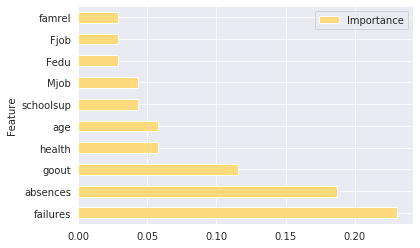

In [65]:
prem[:10].plot.barh(color='#FDDB7D')

`It seems like 'failures', 'absences' are the most two behaviors that impact students' grades. And 'go_out' which is a bad activity in my mom's eyes would also influence grades a lot. But surprisingly, parents' jobs and 'education of father' also impact a little bit. 
'Failures' makes a lot of sense to me, to be honest if you failed lots of tests in the past, you probably will fail other tests in the future. And that opinion indicates we could get better performance if we build our model with past scores(using setB or setA). 
'Absences', 'go_out', and 'health' combined together, no matter what reasons cause you to miss the class, maybe you skip the class or caused by personal health status, will impact your grades a lot.
Other behaviors like 'schoolsup'(extra educational support), parents' jobs, parents' education, and 'famrel'(family relationship) point out that environment also very important for students.` 

In [362]:
# split data into training and test datasets
X_train, X_test, y_train, y_test = None, None, None, None # make sure X and y are empty
X_train, X_test, y_train, y_test = train_test_split(setA, outputA, test_size = 0.2, random_state=42)

In [363]:
# Save training data and test data
sagemaker_dir = 'sagemaker_data'
exp_dir = 'exp2'
pd.concat([pd.DataFrame(y_train), pd.DataFrame(X_train)],
          axis=1).to_csv(os.path.join(sagemaker_dir, exp_dir, 'train.csv'), 
                    header=False, index=False)
pd.concat([pd.DataFrame(y_test), pd.DataFrame(X_test)],
          axis=1).to_csv(os.path.join(sagemaker_dir, exp_dir, 'test.csv'), 
                    header=False, index=False)

In [364]:
# Upload to s3
prefix = 'student_analysis'
data_s3 = sagemaker_session.upload_data(path=os.path.join(sagemaker_dir, exp_dir),
                                        bucket=bucket,
                                        key_prefix=prefix)
data_s3

's3://sagemaker-us-east-1-980497197870/student_analysis'

In [365]:
model = PyTorch(entry_point='train.py',
                source_dir='pytorch_model',
                role=role,
                train_instance_count=1,
                train_instance_type='ml.p2.xlarge',
                sagemaker_session=sagemaker_session,
                framework_version='1.5.0',
                hyperparameters={'epochs': 800,
                                 'input_features': 28,
                                 'hidden_dim': 128,
                                 'output_dim': 2,
                                 'batch-size': 32})

In [366]:
model.fit({'train': data_s3})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-08-23 07:32:50 Starting - Starting the training job...
2020-08-23 07:32:53 Starting - Launching requested ML instances.........
2020-08-23 07:34:31 Starting - Preparing the instances for training.........
2020-08-23 07:36:03 Downloading - Downloading input data...
2020-08-23 07:36:23 Training - Downloading the training image...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-08-23 07:38:34,490 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-08-23 07:38:34,515 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-08-23 07:38:34,519 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-08-23 07:38:34,826 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020-08-23 07:38:34,827 sagemaker-containers INFO     Generating setup.cfg
2020-08-23 0

Epoch: 42, Loss: 0.09917124211788178
Epoch: 43, Loss: 0.10518338363617659
Epoch: 44, Loss: 0.09787811022251844
Epoch: 45, Loss: 0.07875918969511986
Epoch: 46, Loss: 0.06460476033389569
Epoch: 47, Loss: 0.07358295973390341
Epoch: 48, Loss: 0.08595627155154943
Epoch: 49, Loss: 0.08700878527015447
Epoch: 50, Loss: 0.07215681560337543
Epoch: 51, Loss: 0.10821286886930466
Epoch: 52, Loss: 0.12613803073763846
Epoch: 53, Loss: 0.07290306501090527
Epoch: 54, Loss: 0.06820017006248236
Epoch: 55, Loss: 0.06948083303868771
Epoch: 56, Loss: 0.07002148460596799
Epoch: 57, Loss: 0.073261946067214
Epoch: 58, Loss: 0.09383432352915407
Epoch: 59, Loss: 0.06874192543327809
Epoch: 60, Loss: 0.07055798303335906
Epoch: 61, Loss: 0.07061229795217513
Epoch: 62, Loss: 0.061813260149210694
Epoch: 63, Loss: 0.0473599114920944
Epoch: 64, Loss: 0.04344659298658371
Epoch: 65, Loss: 0.04386383267119527
Epoch: 66, Loss: 0.04803644986823201
Epoch: 67, Loss: 0.056879681348800656
Epoch: 68, Loss: 0.0481849454343319
Epo

Epoch: 319, Loss: 0.002931349497521296
Epoch: 320, Loss: 0.0030569894050131554
Epoch: 321, Loss: 0.0012233483073941897
Epoch: 322, Loss: 0.003507012009868049
Epoch: 323, Loss: 0.0027082744578365236
Epoch: 324, Loss: 0.002184111859241966
Epoch: 325, Loss: 0.002851227202336304
Epoch: 326, Loss: 0.006297766455099918
Epoch: 327, Loss: 0.0022714640566846357
Epoch: 328, Loss: 0.0008713544841157273
Epoch: 329, Loss: 0.0003546580148395151
Epoch: 330, Loss: 0.00952474421574152
Epoch: 331, Loss: 0.007402808760525658
Epoch: 332, Loss: 0.005173870200815145
Epoch: 333, Loss: 0.009106892629642972
Epoch: 334, Loss: 0.0037305439218471292
Epoch: 335, Loss: 0.025373935644165613
Epoch: 336, Loss: 0.034110866274568254
Epoch: 337, Loss: 0.021965836684103124
Epoch: 338, Loss: 0.005623065517283976
Epoch: 339, Loss: 0.001618399264407344
Epoch: 340, Loss: 0.003476704157947097
Epoch: 341, Loss: 0.0016242987432633527
Epoch: 342, Loss: 0.0011230756739678328
Epoch: 343, Loss: 0.004694550210842863
Epoch: 344, Loss:


2020-08-23 07:39:18 Uploading - Uploading generated training modelEpoch: 733, Loss: 0.007486111717298627
Epoch: 734, Loss: 0.0019231178186601028
Epoch: 735, Loss: 0.003588989199488424
Epoch: 736, Loss: 0.004005329213032383
Epoch: 737, Loss: 0.0021468170481966807
Epoch: 738, Loss: 0.0009146784013864817
Epoch: 739, Loss: 0.0028924703157827024
Epoch: 740, Loss: 0.0007179656975495163
Epoch: 741, Loss: 0.00042172282373940104
Epoch: 742, Loss: 0.0006793871147237951
Epoch: 743, Loss: 0.0008881425368599593
Epoch: 744, Loss: 0.0005134964252647478
Epoch: 745, Loss: 0.0009819139100727624
Epoch: 746, Loss: 0.0002246235205348057
Epoch: 747, Loss: 0.00012032976337650325
Epoch: 748, Loss: 0.0005754693525886978
Epoch: 749, Loss: 0.00047386603655468206
Epoch: 750, Loss: 0.00015140777031774633
Epoch: 751, Loss: 0.00014143523376333177
Epoch: 752, Loss: 0.0006796796544222162
Epoch: 753, Loss: 0.0003003711950441357
Epoch: 754, Loss: 0.0005717687365176972
Epoch: 755, Loss: 0.0003196403951733373
Epoch: 756,

In [369]:
predictor = model.deploy(instance_type = 'ml.c4.xlarge',
                         initial_instance_count = 1)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!

In [370]:
test_data = pd.read_csv(os.path.join(sagemaker_dir, exp_dir, 'test.csv'), header=None, names=None)
y_test = test_data.iloc[:,[0,1]]
X_test = test_data.iloc[:,2:]

In [372]:
X_test = X_test.astype('float32')
test_y_preds = np.squeeze(np.rint(predictor.predict(X_test))).astype(int)
test_y_preds[:10]

array([[1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1]])

In [373]:
r = 0
for idx in range(len(tdata)):
    if tdata[idx][0] == test_y_preds[idx][0] and tdata[idx][1] == test_y_preds[idx][1]:
        r+=1
1.0 * r / len(tdata)

0.8860759493670886